In [1]:
import json
from collections import OrderedDict
import spacy
import os
from natsort import natsort_key
import pandas as pd
import random
import re

import sys
sys.path.append('/Users/pfq/Dropbox/DTA/Thesis_Internship/thesis/ner')
from my_functions import get_tokens, replacer, get_distribution, splitter, preprocess_for_lexical, lexi_maker, predict_labels, evaluator

#### File and Directory Declarations

In [2]:
# — — corpus — —

# Corpus: original letters

letters = "/Users/pfq/Dropbox/DTA/Thesis_Internship/thesis/letters.json"

# — — NER subcorpus — —

# NER subcorpus directory, one xml file per letter

annotated_corpus_dir = "/Users/pfq/Dropbox/DTA/Thesis_Internship/thesis/VARD2.5.4/annotated_corpus"

# NER subcorpus: original letters, original spelling (pre-preprocessing version)

raw_ner_corpus = "/Users/pfq/Dropbox/DTA/Thesis_Internship/thesis/VARD2.5.4/ner_corpus/raw_ner_corpus.csv"

# NER subcorpus: VARDed letters, VARD f-score 1 threshold 0 (pre-preprocessing version)

v_f1t0 = "/Users/pfq/Dropbox/DTA/Thesis_Internship/thesis/VARD2.5.4/ner_corpus/VARD_fscore_1.0_threshold_0.csv"

#### spaCy Functions

In [3]:
def indexed_process_text(text):
    '''
    Processes the input text using spaCy's NER and returns a list of tuples
    representing the entities found with their corresponding tags.

    The function maps my custom tags to spaCy tags as follows:
        [my tag] = [Spacy tags]
        NAME = PERSON
        LOCATION = GPE, FAC, ORG, LOC
        NATION = NORP
        DATE = DATE
        PRICE = MONEY

    Parameters:
        text (str): The input text to be processed.

    Returns:
        list: A list of tuples representing the entities found in the text and their corresponding tags.
              Each tuple contains three elements: (start_index, entity_tag, entity_text).
    '''
    doc = nlp(text)
    entities = []
    for token in doc:
        if token.ent_type_ in ('PERSON', 'GPE', 'FAC', 'ORG', 'LOC', 'NORP', 'DATE', 'MONEY'):
            entities.append((token.idx,f'{token.ent_type_}-{token.ent_iob_}',token.text))
        else:
            entities.append((token.idx,'O',token.text))
    return entities

In [4]:
def transform_spacy_labels(lst):
    '''
    Transforms a list of spaCy NER tags to my custom tags.

    The function uses the following mapping to convert spaCy tags to custom tags:
        my tag = spaCy tags
        NAME = PERSON
        LOCATION = GPE, FAC, ORG, LOC
        NATION = NORP
        DATE = DATE
        PRICE = MONEY

    Parameters:
        lst (list): A list of spaCy NER tags to be transformed.

    Returns:
        list: A new list with spaCy tags converted to my custom tags as per the specified mapping.
    '''
    for i in range(len(lst)):
        element = lst[i]
        if element == 'PERSON-B':
            lst[i] = 'NAME-B'
        elif element == 'PERSON-I':
            lst[i] = 'NAME-I'
        elif element == 'GPE-B' or element == 'FAC-B' or element == 'ORG-B' or element == 'LOC-B':
            lst[i] = 'LOCATION-B'
        elif element == 'GPE-I' or element == 'FAC-I' or element == 'ORG-I' or element == 'LOC-I':
            lst[i] = 'LOCATION-I'
        elif element == 'NORP-B':
            lst[i] = 'NATION-B'
        elif element == 'NORP-I':
            lst[i] = 'NATION-I'
        elif element == 'MONEY-B':
            lst[i] = 'PRICE-B'
        elif element == 'MONEY-I':
            lst[i] = 'PRICE-I'

# spaCy Baseline

#### Using `raw_ner_corpus`
$\to$ spaCy processes one line at a time\
$\to$ spaCy predictions reconciled with true labelling for entire NER Subcorpus

##### Data Preparation

In [5]:
# get list of annotated letters from file list of folder of annotated letters

annotated_corpus_list = os.listdir(annotated_corpus_dir)

# sort list so that the letters are in the same order as the df, from which true labels will be read

annotated_corpus = [os.path.splitext(f)[0] for f in sorted(annotated_corpus_list, key=natsort_key)]

In [6]:
# process the letters in the original json file into the same order as the df

spacy_letters = []

with open(letters) as json_file:
    letters = json.load(json_file)

for f in annotated_corpus:
    for letter in letters:
        letter_id = letter['_id']
        text = letter['text']
        if f == letter_id:
            output = {
                "_id" : letter_id,
                "text" : text
            }
            spacy_letters.append(output)

# process the letters as per the creation of the corpus to preserve indexing across project

# save as json file from which we can work

for f in spacy_letters:
    new_text = []
    for word in f['text']:
        word = ' '.join(word.split())
        new_word = replacer(word)
        new_text.append(new_word)
    f['text'] = new_text

with open('raw_ner_corpus.json', 'w') as f:
    json.dump(spacy_letters, f, indent=4)

In [7]:
# open json file and prepare data for reconciling spaCy tokenization with true label enumeration

with open("raw_ner_corpus.json") as f:
    data = json.load(f, object_pairs_hook=OrderedDict)

# process letters with spaCy to create list of tuples with index

# prepare the letters for reconciliation with labels based on character index

nlp = spacy.load('en_core_web_sm')

spacy_raw_indexed = []
line_raw = []
for letter in data:
    for line in letter['text']:
        line_raw.append(line)
        l = indexed_process_text(line)
        spacy_raw_indexed.append(l)

In [8]:
# check the output lists

line_raw[0], spacy_raw_indexed[0], line_raw[-1], spacy_raw_indexed[-1]

('1. OTWELL JOHNSON TO JOHN JOHNSON',
 [(0, 'O', '1'),
  (1, 'O', '.'),
  (3, 'ORG-B', 'OTWELL'),
  (10, 'O', 'JOHNSON'),
  (18, 'O', 'TO'),
  (21, 'PERSON-B', 'JOHN'),
  (26, 'PERSON-I', 'JOHNSON')],
 'End. 1552, from George Perott at Caliais, 13 Marche; receyved at London le 17; aunsweryd le dit.',
 [(0, 'O', 'End'),
  (3, 'O', '.'),
  (5, 'DATE-B', '1552'),
  (9, 'O', ','),
  (11, 'O', 'from'),
  (16, 'PERSON-B', 'George'),
  (23, 'PERSON-I', 'Perott'),
  (30, 'O', 'at'),
  (33, 'O', 'Caliais'),
  (40, 'O', ','),
  (42, 'O', '13'),
  (45, 'ORG-B', 'Marche'),
  (51, 'O', ';'),
  (53, 'O', 'receyved'),
  (62, 'O', 'at'),
  (65, 'GPE-B', 'London'),
  (72, 'O', 'le'),
  (75, 'O', '17'),
  (77, 'O', ';'),
  (79, 'O', 'aunsweryd'),
  (89, 'O', 'le'),
  (92, 'O', 'dit'),
  (95, 'O', '.')])

In [9]:
# empty lists are present as a result of line breaks being inherited when reading the original letters in, remove them

spacy_raw_indexed = [sublist for sublist in spacy_raw_indexed if sublist]
line_raw = [sublist for sublist in line_raw if sublist]

In [10]:
# reconcile spaCy NER with enumeration of true labelling

spacy_wd_labels = []
for i in range(len(spacy_raw_indexed)):
    it = get_tokens(spacy_raw_indexed[i])
    next(it)
    out = [it.send(w) for w in line_raw[i].split()]
    spacy_wd_labels.append(out)

In [11]:
# initial check of spaCy's labels

spacy_wd_labels[0], spacy_wd_labels[-1]

([('1.', 'O'),
  ('OTWELL', 'ORG-B'),
  ('JOHNSON', 'O'),
  ('TO', 'O'),
  ('JOHN', 'PERSON-B'),
  ('JOHNSON', 'PERSON-I')],
 [('End.', 'O'),
  ('1552,', 'DATE-B'),
  ('from', 'O'),
  ('George', 'PERSON-B'),
  ('Perott', 'PERSON-I'),
  ('at', 'O'),
  ('Caliais,', 'O'),
  ('13', 'O'),
  ('Marche;', 'ORG-B'),
  ('receyved', 'O'),
  ('at', 'O'),
  ('London', 'GPE-B'),
  ('le', 'O'),
  ('17;', 'O'),
  ('aunsweryd', 'O'),
  ('le', 'O'),
  ('dit.', 'O')])

In [12]:
# open the original letters to retrieve labels

df = pd.read_csv(raw_ner_corpus, sep=',')

# dropna() will drop empty values in word, which are a result of line breaks in the letters

df = df.dropna()
df.head(10)

,word_id,word,NAME,LOCATION,NATION,MARKET,DATE,TIME,PRICE,GOD,labels
0,SB_J_1.0.0,1.,O,O,O,O,O,O,O,O,O
1,SB_J_1.0.1,OTWELL,B,O,O,O,O,O,O,O,NAME-B
2,SB_J_1.0.2,JOHNSON,I,O,O,O,O,O,O,O,NAME-I
3,SB_J_1.0.3,TO,O,O,O,O,O,O,O,O,O
4,SB_J_1.0.4,JOHN,B,O,O,O,O,O,O,O,NAME-B
5,SB_J_1.0.5,JOHNSON,I,O,O,O,O,O,O,O,NAME-I
6,SB_J_1.1.0,At,O,O,O,O,O,O,O,O,O
7,SB_J_1.1.1,"London,",O,B,O,O,O,O,O,O,LOCATION-B
8,SB_J_1.1.2,the,O,O,O,O,B,O,O,O,DATE-B
9,SB_J_1.1.3,12th,O,O,O,O,I,O,O,O,DATE-I


In [13]:
# format list of true labels per sentence in order to check that lengths match

true_labels_sentences = [list(zip(g['word'], g['labels'])) for k, g in
       df.groupby(df['word_id'].str.endswith('.0').cumsum())]

# check output

true_labels_sentences[0], true_labels_sentences[-1]

([('1.', 'O'),
  ('OTWELL', 'NAME-B'),
  ('JOHNSON', 'NAME-I'),
  ('TO', 'O'),
  ('JOHN', 'NAME-B'),
  ('JOHNSON', 'NAME-I')],
 [('End.', 'O'),
  ('1552,', 'DATE-B'),
  ('from', 'O'),
  ('George', 'NAME-B'),
  ('Perott', 'NAME-I'),
  ('at', 'O'),
  ('Caliais,', 'LOCATION-B'),
  ('13', 'DATE-B'),
  ('Marche;', 'DATE-I'),
  ('receyved', 'O'),
  ('at', 'O'),
  ('London', 'LOCATION-B'),
  ('le', 'DATE-B'),
  ('17;', 'DATE-I'),
  ('aunsweryd', 'O'),
  ('le', 'DATE-B'),
  ('dit.', 'DATE-I')])

In [14]:
# check that the length of the true labels and spaCy labels are identical, sentence/line at a time

for f, g in zip(true_labels_sentences, spacy_wd_labels):
    if len(f) != len(g):
        print(f, g)

In [15]:
# check for misordered tags, i.e. 'I' before 'B' as a result of reconciling spaCy NER

for f,sublist in enumerate(spacy_wd_labels):
    for i in range(len(sublist) - 1):
        current_tuple = sublist[i]
        next_tuple = sublist[i + 1]
        previous_tuple = sublist[i - 1]
        
        if current_tuple[1].endswith('I') and next_tuple[1].endswith('B') and current_tuple[1][:2] == next_tuple[1][:2]:
            if current_tuple[1].endswith('I') and not previous_tuple[1].endswith('B'):
                if current_tuple[1][:2] != previous_tuple[1][:2]:
                    print(f"index: {f}")

In [16]:
# prepare spaCy labels for evaluation by tranforming to list

spacy_labels = [t[1] for sublist in spacy_wd_labels for t in sublist]

In [17]:
# transform spaCy labels to match that of true labels

transform_spacy_labels(spacy_labels)

In [18]:
# prepare true labels, given that we are only creating a baseline for 'NAME', 'LOCATION', 'NATION', 'DATE', 'PRICE'

# we do not need 'GOD', 'MARKET', 'TIME'

df['labels'] = df['labels'].replace(['GOD-B', 'GOD-I', 'MARKET-B', 'MARKET-I', 'TIME-B', 'TIME-I'], 'O')

true_labels = df['labels'].tolist()

In [19]:
# check that true and spaCy data are identical lengths

len(spacy_labels) == len(true_labels)

True

In [20]:
# prepare labels

labels = sorted(list(set(df['labels'])))

##### Evaluation

accuracy: 0.8923692887423458
f1 average: 0.27669639247614924



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision: [0.18456376 0.57894737 0.39487423 0.07674944 0.39874816 0.64226682
 0.04040404 0.         0.94799327 0.25       0.22222222]
recall: [0.18739353 0.13624511 0.72097054 0.36170213 0.49339408 0.48398577
 0.03603604 0.         0.96421986 0.00340716 0.00319489]
f1: [0.18596788 0.22058047 0.51027292 0.12662942 0.4410507  0.55200406
 0.03809524 0.         0.95603772 0.00672269 0.00629921]



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

      DATE-B       0.18      0.19      0.19       587
      DATE-I       0.58      0.14      0.22      1534
  LOCATION-B       0.39      0.72      0.51      1154
  LOCATION-I       0.08      0.36      0.13        94
      NAME-B       0.40      0.49      0.44      2195
      NAME-I       0.64      0.48      0.55      2248
    NATION-B       0.04      0.04      0.04       111
    NATION-I       0.00      0.00      0.00        48
           O       0.95      0.96      0.96     67244
     PRICE-B       0.25      0.00      0.01       587
     PRICE-I       0.22      0.00      0.01       626

    accuracy                           0.89     76428
   macro avg       0.34      0.31      0.28     76428
weighted avg       0.89      0.89      0.88     76428



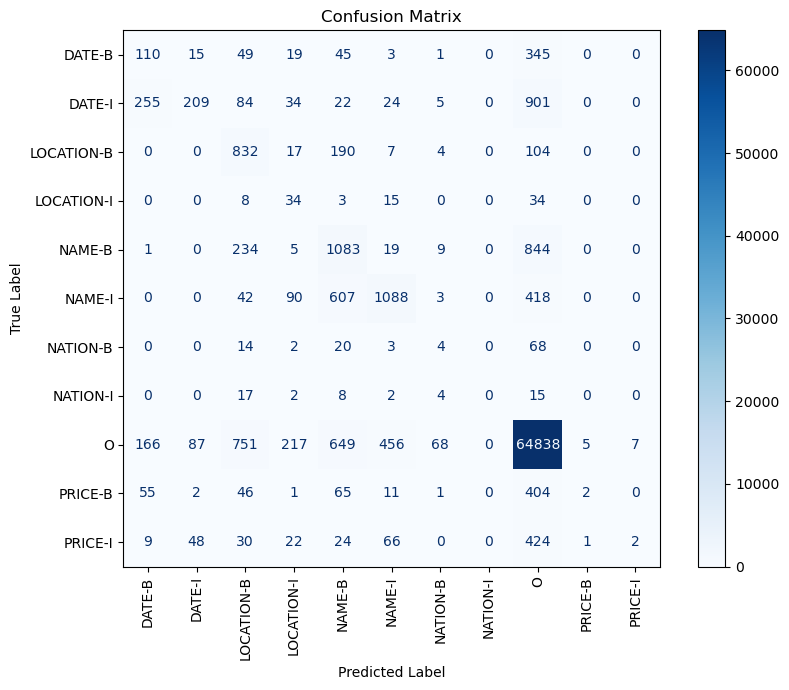

In [21]:
evaluator(true_labels, spacy_labels, labels, size='big')

#### Using `v_f1t0`
$\to$ spaCy processes one line at a time\
$\to$ spaCy predictions reconciled with true labelling for entire NER Subcorpus

##### Data Preparation

In [22]:
# open letters, VARDed version

df = pd.read_csv(v_f1t0, sep=',')

# dropna() will drop empty values in word, which are a result of line breaks in the letters

df = df.dropna()
df.head(10)

,word_id,word,NAME,LOCATION,NATION,MARKET,DATE,TIME,PRICE,GOD,labels
0,SB_J_1.0.0,1.,O,O,O,O,O,O,O,O,O
1,SB_J_1.0.1,HOTEL,B,O,O,O,O,O,O,O,NAME-B
2,SB_J_1.0.2,JOHNSON,I,O,O,O,O,O,O,O,NAME-I
3,SB_J_1.0.3,TO,O,O,O,O,O,O,O,O,O
4,SB_J_1.0.4,JOHN,B,O,O,O,O,O,O,O,NAME-B
5,SB_J_1.0.5,JOHNSON,I,O,O,O,O,O,O,O,NAME-I
6,SB_J_1.1.0,At,O,O,O,O,O,O,O,O,O
7,SB_J_1.1.1,"London,",O,B,O,O,O,O,O,O,LOCATION-B
8,SB_J_1.1.2,the,O,O,O,O,B,O,O,O,DATE-B
9,SB_J_1.1.3,12th,O,O,O,O,I,O,O,O,DATE-I


In [23]:
# VARD has transformed some single words into multiple words

# these will be tokenized by spaCy, thus we need to preventitvely pre-tokenise them, allocating one word per row

# this will preserve associated true labels and in turn the length of the true data and spaCy data

df_whitespace_rows = df[df['word'].str.contains('\s')]
print(len(df[df['word'].str.contains('\s')]))
df_whitespace_rows.head(10)

88


,word_id,word,NAME,LOCATION,NATION,MARKET,DATE,TIME,PRICE,GOD,labels
264,SB_J_1.3.185,how be it,O,O,O,O,O,O,O,O,O
555,SB_J_2.2.45,"How be it,",O,O,O,O,O,O,O,O,O
3986,SB_J_8.2.81,how be it,O,O,O,O,O,O,O,O,O
4107,SB_J_8.2.202,How be it,O,O,O,O,O,O,O,O,O
6128,SB_J_14.4.50,How be it,O,O,O,O,O,O,O,O,O
6211,SB_J_14.6.28,"How be it,",O,O,O,O,O,O,O,O,O
7563,SB_J_18.14.67,"How be it,",O,O,O,O,O,O,O,O,O
7714,SB_J_21.6.56,"Were it,",I,O,O,O,O,O,O,O,NAME-I
7740,SB_J_21.6.82,the other,O,O,O,O,O,O,O,O,O
10121,SB_J_33.7.62,"As well,",O,B,O,O,O,O,O,O,LOCATION-B


In [24]:
# because VARD has replaced some single tokens with multiple tokens we need to first adjust the word indexing in word_id

# to accomodate this we split any word values with whitespace on whitespace creating new rows and sensibly update the BIO labels

new_rows = []
for index, row in df.iterrows():
    tokens = row['word'].split()
    if len(tokens) ==1:
        row['token'] = row['word']
        new_rows.append(row)
    else:
        for i, token in enumerate(tokens):
            row_copy = df.loc[index].copy()
            row_copy['token'] = token
            cols = ['NAME', 'LOCATION', 'NATION', 'MARKET', 'DATE', 'TIME', 'PRICE', 'GOD']
            if i > 0:
                for column in cols:
                    if row_copy[column] == 'B':
                        row_copy[column] = 'I'
                row_copy['word_id'] += f'.{i}'
                row_copy['word'] = ''
            new_rows.append(row_copy)

# add new row of tokenized words to df

df = pd.concat(new_rows, axis=1).transpose().reset_index(drop=True)

# reorder the columns for readability

df.insert(2, 'token', df.pop('token'))

In [25]:
# check for the presence of tokens with whitespace

print(len(df[df['token'].str.contains('\s')]))

0


In [26]:
# replace 'labels' column with updated labels following the reindexing of the df

targets = ['NAME', 'LOCATION', 'NATION', 'MARKET', 'DATE', 'TIME', 'PRICE', 'GOD']

df['labels'] = df[targets].apply(lambda row: next((col + '-B' for col in targets if row[col] == 'B'),
                                                    next((col + '-I' for col in targets if row[col] == 'I'), 'O')), axis=1)

In [27]:
# create json file of sentences from VARDed letters to pass to spaCy

# note that this isn't a well-formed json file; we will dump the list of strings directly to the file

# new lines end with an index of ".0"

v_words = [list(g['token']) for k, g in
       df.groupby(df['word_id'].str.endswith('.0').cumsum())]

full_strings = [' '.join(lst) for lst in v_words]

with open('v_f1t0.json', 'w') as file:
    json.dump(full_strings, file, indent=4)

In [28]:
# open json file and prepare data for reconciling spaCy tokenization with true label enumeration

with open("v_f1t0.json") as f:
    data = json.load(f)

# process letters with spaCy to create list of tuples with index

# prepare the letters for reconciliation with labels based on character index

spacy_v_f1t0 = []
v_f1t0_raw = []
for line in data:
    v_f1t0_raw.append(line)
    l = indexed_process_text(line)
    spacy_v_f1t0.append(l)

In [29]:
# check the output lists

v_f1t0_raw[0], spacy_v_f1t0[0], v_f1t0_raw[-1], spacy_v_f1t0[-1]

('1. HOTEL JOHNSON TO JOHN JOHNSON',
 [(0, 'O', '1'),
  (1, 'O', '.'),
  (3, 'ORG-B', 'HOTEL'),
  (9, 'O', 'JOHNSON'),
  (17, 'O', 'TO'),
  (20, 'PERSON-B', 'JOHN'),
  (25, 'PERSON-I', 'JOHNSON')],
 'End. 1552, from George Perth at Calais, 13 March; received at London le 17; answered le died.',
 [(0, 'O', 'End'),
  (3, 'O', '.'),
  (5, 'DATE-B', '1552'),
  (9, 'O', ','),
  (11, 'O', 'from'),
  (16, 'PERSON-B', 'George'),
  (23, 'PERSON-I', 'Perth'),
  (29, 'O', 'at'),
  (32, 'GPE-B', 'Calais'),
  (38, 'O', ','),
  (40, 'DATE-B', '13'),
  (43, 'DATE-I', 'March'),
  (48, 'O', ';'),
  (50, 'O', 'received'),
  (59, 'O', 'at'),
  (62, 'GPE-B', 'London'),
  (69, 'O', 'le'),
  (72, 'O', '17'),
  (74, 'O', ';'),
  (76, 'O', 'answered'),
  (85, 'O', 'le'),
  (88, 'O', 'died'),
  (92, 'O', '.')])

In [30]:
# reconcile spaCy NER with enumeration of true labelling

spacy_wd_labels_v = []
for i in range(len(spacy_v_f1t0)):
    it = get_tokens(spacy_v_f1t0[i])
    next(it)
    out = [it.send(w) for w in v_f1t0_raw[i].split()]
    spacy_wd_labels_v.append(out)

In [31]:
# initial check of spaCy's labels

spacy_wd_labels_v[0], spacy_wd_labels_v[-1]

([('1.', 'O'),
  ('HOTEL', 'ORG-B'),
  ('JOHNSON', 'O'),
  ('TO', 'O'),
  ('JOHN', 'PERSON-B'),
  ('JOHNSON', 'PERSON-I')],
 [('End.', 'O'),
  ('1552,', 'DATE-B'),
  ('from', 'O'),
  ('George', 'PERSON-B'),
  ('Perth', 'PERSON-I'),
  ('at', 'O'),
  ('Calais,', 'GPE-B'),
  ('13', 'DATE-B'),
  ('March;', 'DATE-I'),
  ('received', 'O'),
  ('at', 'O'),
  ('London', 'GPE-B'),
  ('le', 'O'),
  ('17;', 'O'),
  ('answered', 'O'),
  ('le', 'O'),
  ('died.', 'O')])

In [32]:
# format list of true labels per sentence using 'token' column in order to check that lengths match

true_labels_sentences = [list(zip(g['token'], g['labels'])) for k, g in
       df.groupby(df['word_id'].str.endswith('.0').cumsum())]

# check output

true_labels_sentences[0], true_labels_sentences[-1]

([('1.', 'O'),
  ('HOTEL', 'NAME-B'),
  ('JOHNSON', 'NAME-I'),
  ('TO', 'O'),
  ('JOHN', 'NAME-B'),
  ('JOHNSON', 'NAME-I')],
 [('End.', 'O'),
  ('1552,', 'DATE-B'),
  ('from', 'O'),
  ('George', 'NAME-B'),
  ('Perth', 'NAME-I'),
  ('at', 'O'),
  ('Calais,', 'LOCATION-B'),
  ('13', 'DATE-B'),
  ('March;', 'DATE-I'),
  ('received', 'O'),
  ('at', 'O'),
  ('London', 'LOCATION-B'),
  ('le', 'DATE-B'),
  ('17;', 'DATE-I'),
  ('answered', 'O'),
  ('le', 'DATE-B'),
  ('died.', 'DATE-I')])

In [33]:
# check that the length of the true labels and spaCy labels are identical, sentence/line at a time

for f, g in zip(true_labels_sentences, spacy_wd_labels_v):
    if len(f) != len(g):
        print(f, g)

In [34]:
# check for misordered tags, i.e. 'I' before 'B' as a result of reconciling spaCy NER

for f,sublist in enumerate(spacy_wd_labels_v):
    for i in range(len(sublist) - 1):
        current_tuple = sublist[i]
        next_tuple = sublist[i + 1]
        previous_tuple = sublist[i - 1]
        
        if current_tuple[1].endswith('I') and next_tuple[1].endswith('B') and current_tuple[1][:2] == next_tuple[1][:2]:
            if current_tuple[1].endswith('I') and not previous_tuple[1].endswith('B'):
                if current_tuple[1][:2] != previous_tuple[1][:2]:
                    print(f"index: {f}")

In [35]:
# prepare spaCy labels for evaluation by tranforming to list

spacy_labels = [t[1] for sublist in spacy_wd_labels_v for t in sublist]

In [36]:
# transform spaCy labels to match that of true labels

transform_spacy_labels(spacy_labels)

In [37]:
# prepare true labels, given that we are only creating a baseline for 'NAME', 'LOCATION', 'NATION', 'DATE', 'PRICE'

# we do not need 'GOD', 'MARKET', 'TIME'

df['labels'] = df['labels'].replace(['GOD-B', 'GOD-I', 'MARKET-B', 'MARKET-I', 'TIME-B', 'TIME-I'], 'O')

true_labels = df['labels'].tolist()

In [38]:
# prepare labels

labels = sorted(list(set(df['labels'])))

##### Evaluation

accuracy: 0.9020755234525006
f1 average: 0.3194398858553501

precision: [0.15592516 0.5148248  0.52414681 0.09071274 0.48441797 0.75884956
 0.2278481  0.         0.94744068 0.5        0.41666667]
recall: [0.25553663 0.24902216 0.70537262 0.44210526 0.48154897 0.45753668
 0.16216216 0.         0.97310495 0.00681431 0.00798722]
f1: [0.19367334 0.33567663 0.60140377 0.15053763 0.48297921 0.57087379
 0.18947368 0.         0.96010134 0.01344538 0.01567398]

              precision    recall  f1-score   support

      DATE-B       0.16      0.26      0.19       587
      DATE-I       0.51      0.25      0.34      1534
  LOCATION-B       0.52      0.71      0.60      1154
  LOCATION-I       0.09      0.44      0.15        95
      NAME-B       0.48      0.48      0.48      2195
      NAME-I       0.76      0.46      0.57      2249
    NATION-B       0.23      0.16      0.19       111
    NATION-I       0.00      0.00      0.00        48
           O       0.95      0.97      0.96     67373
  

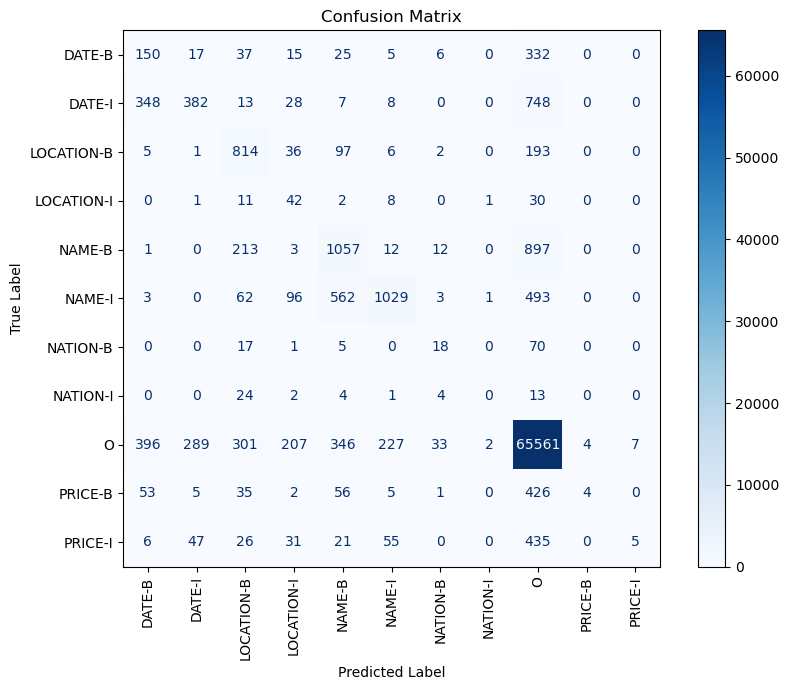

In [39]:
evaluator(true_labels, spacy_labels, labels, size='big')

# Lexical Look-Up + Regular Expression Baseline

#### Using `raw_ner_corpus`
$\to$ processing entire NER Subcorpus\
$\to$ matches reconciled with true labelling for entire NER corpus\

$\to$ lexical look-up: `NAME`, `LOCATION`, `NATION`, `MARKET`, `TIME`, `GOD`\
$\to$ regular expression: `DATE`, `PRICE` 

In [40]:
# set local split for splitter function for the notebook

splitter_split = 0.8

##### Lexical look-up: `NAME`

In [41]:
# open the original letters to retrieve labels

df = pd.read_csv(raw_ner_corpus, sep=',')

# dropna() will drop empty values in word, which are a result of line breaks in the letters

df = df.dropna()
df.head(10)

,word_id,word,NAME,LOCATION,NATION,MARKET,DATE,TIME,PRICE,GOD,labels
0,SB_J_1.0.0,1.,O,O,O,O,O,O,O,O,O
1,SB_J_1.0.1,OTWELL,B,O,O,O,O,O,O,O,NAME-B
2,SB_J_1.0.2,JOHNSON,I,O,O,O,O,O,O,O,NAME-I
3,SB_J_1.0.3,TO,O,O,O,O,O,O,O,O,O
4,SB_J_1.0.4,JOHN,B,O,O,O,O,O,O,O,NAME-B
5,SB_J_1.0.5,JOHNSON,I,O,O,O,O,O,O,O,NAME-I
6,SB_J_1.1.0,At,O,O,O,O,O,O,O,O,O
7,SB_J_1.1.1,"London,",O,B,O,O,O,O,O,O,LOCATION-B
8,SB_J_1.1.2,the,O,O,O,O,B,O,O,O,DATE-B
9,SB_J_1.1.3,12th,O,O,O,O,I,O,O,O,DATE-I


In [42]:
# construct list of lists of tuples, with each list of tuples representing one sentence and its labels

raw_data = [list(zip(g['word'], g['NAME'])) for k, g in 
            df.groupby(df['word_id'].str.endswith('.0').cumsum())]

# shuffle data

random.shuffle(raw_data)

In [43]:
# split the data into train and test

dist = get_distribution(raw_data)
train_bin, test_bin = splitter(raw_data, splitter_split, dist)
len(raw_data), len(train_bin), len(test_bin)

Desired split: 0.8
Actual split: 0.8


(1692, 1319, 373)

In [44]:
# preprocess training and test data

train_bin = preprocess_for_lexical(train_bin)
test_bin = preprocess_for_lexical(test_bin)

# make lexicon for labels

lexical_dict = lexi_maker(train_bin)

# make predictions

name_pred = predict_labels(test_bin, lexical_dict)

# check that lengths match

len(name_pred[0]), len(name_pred[1]), len(name_pred[2]), len(test_bin[0]), len(test_bin[1]), len(test_bin[2])

(15, 9, 4, 15, 9, 4)

In [45]:
# create list of predictions

name_preds = [f[1] for sublist in name_pred for f in sublist]

# create list of true labels

name_true = [f[1] for sublist in test_bin for f in sublist]

# prepare labels

labels = ['B', 'I', 'O']

##### Evaluation

accuracy: 0.8544165435745938
f1 average: 0.5404045904758364

precision: [0.2187858  0.23904382 0.98958633]
recall: [0.87015945 0.66518847 0.85930776]
f1: [0.34965675 0.35169988 0.91985714]

              precision    recall  f1-score   support

           B       0.22      0.87      0.35       439
           I       0.24      0.67      0.35       451
           O       0.99      0.86      0.92     16035

    accuracy                           0.85     16925
   macro avg       0.48      0.80      0.54     16925
weighted avg       0.95      0.85      0.89     16925



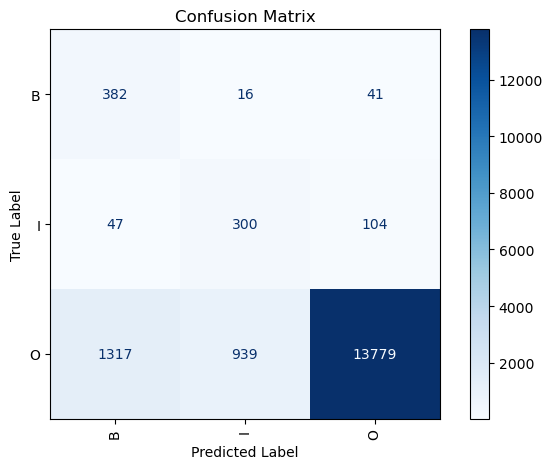

In [46]:
evaluator(name_true, name_preds, labels)

##### Lexical look-up: `LOCATION`

In [47]:
# construct list of lists of tuples, with each list of tuples representing one sentence and its labels

raw_data = [list(zip(g['word'], g['LOCATION'])) for k, g in 
            df.groupby(df['word_id'].str.endswith('.0').cumsum())]

# shuffle data

random.shuffle(raw_data)

In [48]:
# split the data into train and test

dist = get_distribution(raw_data)
train_bin, test_bin = splitter(raw_data, splitter_split, dist)
len(raw_data), len(train_bin), len(test_bin)

Desired split: 0.8
Actual split: 0.8016


(1692, 1370, 322)

In [49]:
# preprocess training and test data

train_bin = preprocess_for_lexical(train_bin)
test_bin = preprocess_for_lexical(test_bin)

# make lexicon for labels

lexical_dict = lexi_maker(train_bin)

# make predictions

loc_pred = predict_labels(test_bin, lexical_dict)

# check lengths

len(loc_pred[0]), len(loc_pred[1]), len(loc_pred[2]), len(test_bin[0]), len(test_bin[1]), len(test_bin[2])

(4, 362, 3, 4, 362, 3)

In [50]:
# create list of predictions

loc_preds = [f[1] for sublist in loc_pred for f in sublist]

# create list of true labels

loc_true = [f[1] for sublist in test_bin for f in sublist]

##### Evaluation

accuracy: 0.9048961333415038
f1 average: 0.4294837886140406

precision: [0.1971831  0.01195219 0.99542443]
recall: [0.79475983 0.26470588 0.90782262]
f1: [0.31597222 0.02287166 0.94960748]

              precision    recall  f1-score   support

           B       0.20      0.79      0.32       229
           I       0.01      0.26      0.02        34
           O       1.00      0.91      0.95     16056

    accuracy                           0.90     16319
   macro avg       0.40      0.66      0.43     16319
weighted avg       0.98      0.90      0.94     16319



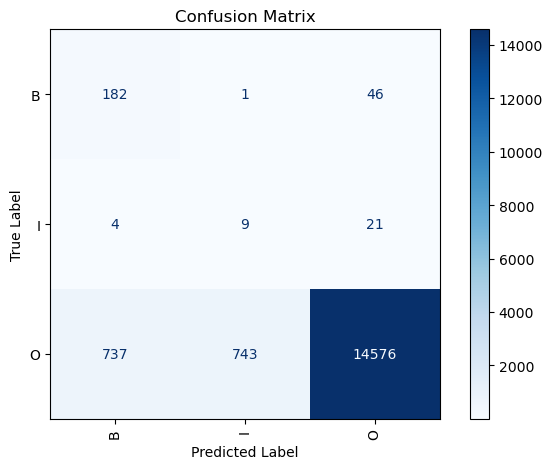

In [51]:
evaluator(loc_true, loc_preds, labels)

##### Lexical look-up: `NATION`

In [52]:
# construct list of lists of tuples, with each list of tuples representing one sentence and its labels

raw_data = [list(zip(g['word'], g['NATION'])) for k, g in 
            df.groupby(df['word_id'].str.endswith('.0').cumsum())]

# shuffle data

random.shuffle(raw_data)

In [53]:
# split the data into train and test

dist = get_distribution(raw_data)
train_bin, test_bin = splitter(raw_data, splitter_split, dist)
len(raw_data), len(train_bin), len(test_bin)

Desired split: 0.8
Actual split: 0.8018


(1692, 1398, 294)

In [54]:
# preprocess training and test data

train_bin = preprocess_for_lexical(train_bin)
test_bin = preprocess_for_lexical(test_bin)

# make lexicon for labels

lexical_dict = lexi_maker(train_bin)

# make predictions

nat_pred = predict_labels(test_bin, lexical_dict)

# check lengths

len(nat_pred[0]), len(nat_pred[1]), len(nat_pred[2]), len(test_bin[0]), len(test_bin[1]), len(test_bin[2])

(118, 11, 87, 118, 11, 87)

In [55]:
# create list of predictions

nat_preds = [f[1] for sublist in nat_pred for f in sublist]

# create list of true labels

nat_true = [f[1] for sublist in test_bin for f in sublist]

##### Evaluation

accuracy: 0.9529368843487778
f1 average: 0.4409172325449307

precision: [0.02018634 0.66666667 0.99900444]
recall: [0.59090909 0.2        0.95407007]
f1: [0.03903904 0.30769231 0.97602035]

              precision    recall  f1-score   support

           B       0.02      0.59      0.04        22
           I       0.67      0.20      0.31        10
           O       1.00      0.95      0.98     13673

    accuracy                           0.95     13705
   macro avg       0.56      0.58      0.44     13705
weighted avg       1.00      0.95      0.97     13705



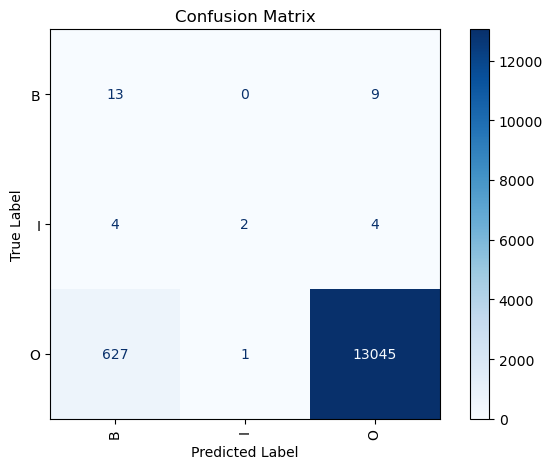

In [56]:
evaluator(nat_true, nat_preds, labels)

##### Lexical look-up: `MARKET`

In [57]:
# construct list of lists of tuples, with each list of tuples representing one sentence and its labels

raw_data = [list(zip(g['word'], g['MARKET'])) for k, g in 
            df.groupby(df['word_id'].str.endswith('.0').cumsum())]

# shuffle data

random.shuffle(raw_data)

In [58]:
# split the data into train and test

dist = get_distribution(raw_data)
train_bin, test_bin = splitter(raw_data, splitter_split, dist)
len(raw_data), len(train_bin), len(test_bin)

Desired split: 0.8
Actual split: 0.8033


(1692, 1424, 268)

In [59]:
# preprocess training and test data

train_bin = preprocess_for_lexical(train_bin)
test_bin = preprocess_for_lexical(test_bin)

# make lexicon for labels

lexical_dict = lexi_maker(train_bin)

# make predictions

mark_pred = predict_labels(test_bin, lexical_dict)

# check lengths

len(mark_pred[0]), len(mark_pred[1]), len(mark_pred[2]), len(test_bin[0]), len(test_bin[1]), len(test_bin[2])

(9, 18, 2, 9, 18, 2)

In [60]:
# create list of predictions

mark_preds = [f[1] for sublist in mark_pred for f in sublist]

# create list of true labels

mark_true = [f[1] for sublist in test_bin for f in sublist]

##### Evaluation

accuracy: 0.9377907978631742
f1 average: 0.4851114948869859

precision: [0.01536313 0.34782609 0.99981596]
recall: [0.91666667 0.66666667 0.93809359]
f1: [0.03021978 0.45714286 0.96797185]

              precision    recall  f1-score   support

           B       0.02      0.92      0.03        12
           I       0.35      0.67      0.46        12
           O       1.00      0.94      0.97     11582

    accuracy                           0.94     11606
   macro avg       0.45      0.84      0.49     11606
weighted avg       1.00      0.94      0.97     11606



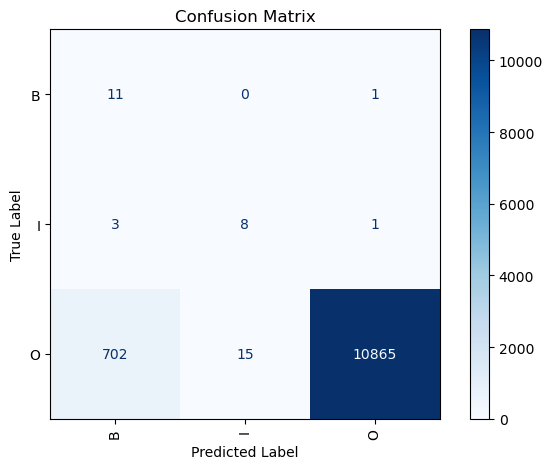

In [61]:
evaluator(mark_true, mark_preds, labels)

##### Lexical look-up: `TIME`

In [62]:
# construct list of lists of tuples, with each list of tuples representing one sentence and its labels

raw_data = [list(zip(g['word'], g['TIME'])) for k, g in 
            df.groupby(df['word_id'].str.endswith('.0').cumsum())]

# shuffle data

random.shuffle(raw_data)

In [63]:
# split the data into train and test

dist = get_distribution(raw_data)
train_bin, test_bin = splitter(raw_data, splitter_split, dist)
len(raw_data), len(train_bin), len(test_bin)

Desired split: 0.8
Actual split: 0.8043


(1692, 1373, 319)

In [64]:
# preprocess training and test data

train_bin = preprocess_for_lexical(train_bin)
test_bin = preprocess_for_lexical(test_bin)

# make lexicon for labels

lexical_dict = lexi_maker(train_bin)

# make predictions

time_pred = predict_labels(test_bin, lexical_dict)

# check lengths

len(time_pred[0]), len(time_pred[1]), len(time_pred[2]), len(test_bin[0]), len(test_bin[1]), len(test_bin[2])

(97, 103, 2, 97, 103, 2)

In [65]:
# create list of predictions

time_preds = [f[1] for sublist in time_pred for f in sublist]

# create list of true labels

time_true = [f[1] for sublist in test_bin for f in sublist]

##### Evaluation

accuracy: 0.705099926475503
f1 average: 0.3264190384756013

precision: [0.05229682 0.02905492 0.99711926]
recall: [0.74747475 0.77118644 0.70428649]
f1: [0.09775429 0.056      0.82550282]

              precision    recall  f1-score   support

           B       0.05      0.75      0.10        99
           I       0.03      0.77      0.06       118
           O       1.00      0.70      0.83     14744

    accuracy                           0.71     14961
   macro avg       0.36      0.74      0.33     14961
weighted avg       0.98      0.71      0.81     14961



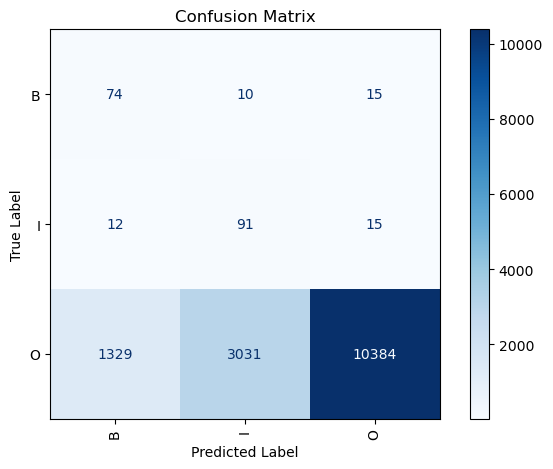

In [66]:
evaluator(time_true, time_preds, labels)

##### Lexical look-up: `GOD`

In [67]:
# construct list of lists of tuples, with each list of tuples representing one sentence and its labels

raw_data = [list(zip(g['word'], g['GOD'])) for k, g in 
            df.groupby(df['word_id'].str.endswith('.0').cumsum())]

# shuffle data

random.shuffle(raw_data)

In [68]:
# split the data into train and test

dist = get_distribution(raw_data)
train_bin, test_bin = splitter(raw_data, splitter_split, dist)
len(raw_data), len(train_bin), len(test_bin)

Desired split: 0.8
Actual split: 0.8051


(1692, 1403, 289)

In [69]:
# preprocess training and test data

train_bin = preprocess_for_lexical(train_bin)
test_bin = preprocess_for_lexical(test_bin)

# make lexicon for labels

lexical_dict = lexi_maker(train_bin)

# make predictions

god_pred = predict_labels(test_bin, lexical_dict)

# check lengths

len(god_pred[0]), len(god_pred[1]), len(god_pred[2]), len(test_bin[0]), len(test_bin[1]), len(test_bin[2])

(5, 21, 10, 5, 21, 10)

In [70]:
# create list of predictions

god_preds = [f[1] for sublist in god_pred for f in sublist]

# create list of true labels

god_true = [f[1] for sublist in test_bin for f in sublist]

##### Evaluation

accuracy: 0.9123625226228596
f1 average: 0.370713516122829

precision: [0.05529412 0.02813853 0.99946377]
recall: [0.87037037 0.65       0.91288833]
f1: [0.1039823  0.05394191 0.95421634]

              precision    recall  f1-score   support

           B       0.06      0.87      0.10        54
           I       0.03      0.65      0.05        20
           O       1.00      0.91      0.95     14292

    accuracy                           0.91     14366
   macro avg       0.36      0.81      0.37     14366
weighted avg       0.99      0.91      0.95     14366



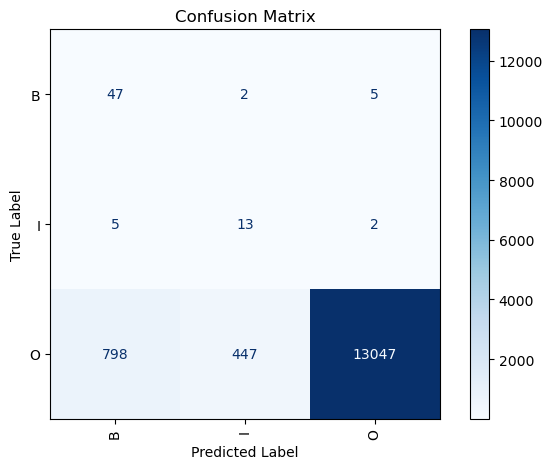

In [71]:
evaluator(god_true, god_preds, labels)

##### Regular expression: `DATE`
$\to$ search full text

In [72]:
# create string of NER subcorpus text

text_raw_ner = ' '.join(df['word'])

In [73]:
# find regex pattern matches and create labels

# pattern = r"(the|le)?( [0-9]+)?( of)?( [A-Z][a-z]+)+"
pattern = r"\b(the\s)?(\d{1,2})(?:(th|st|nd|rd)\b)?(?=\s)"

# find matches, create finditer iterator

matches = re.finditer(pattern, text_raw_ner)

# split text

words = text_raw_ner.split()

# store the labels

date_labels = ['O'] * len(words)

# iterate over the matches and update the date_labels

for match in matches:
    start_index = match.start()
    end_index = match.end()

    # split the matched words
    matched_words = text_raw_ner[start_index:end_index].split()

    # label the first word as 'B'
    date_labels[words.index(matched_words[0])] = 'B'

    # label subsequent words as 'I'
    for i in range(1, len(matched_words)):
        date_labels[words.index(matched_words[i])] = 'I'

In [74]:
# create list of true labels 

date_true = df['DATE'].tolist()

##### Evaluation

accuracy: 0.9721044643324436
f1 average: 0.3417787526380778

precision: [0.11764706 0.69565217 0.97275847]
recall: [0.01022147 0.01043025 0.9995559 ]
f1: [0.01880878 0.02055234 0.98597514]

              precision    recall  f1-score   support

           B       0.12      0.01      0.02       587
           I       0.70      0.01      0.02      1534
           O       0.97      1.00      0.99     74307

    accuracy                           0.97     76428
   macro avg       0.60      0.34      0.34     76428
weighted avg       0.96      0.97      0.96     76428



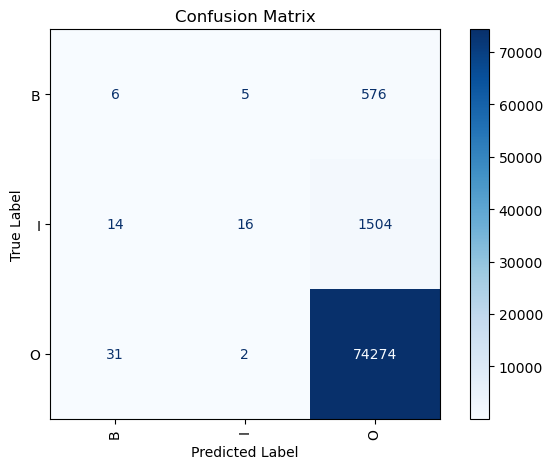

In [75]:
evaluator(date_true, date_labels, labels)

##### Regular expression: `PRICE`
$\to$ iterating through the `df` to match on word tokens

In [76]:
B_patterns = ["\\b\w*li\\b|\\bli\\b", "\\b.*ij\\b", "\w*xx\w*"]
I_patterns = ["\\bst\.", "\\bFl\."]

In [77]:
# define function to check if a token matches regex patterns

def check_regex(token):
    for pattern in B_patterns:
        if re.match(pattern, token):
            return 'B'
    for pattern in I_patterns:
        if re.match(pattern, token):
            return 'I'
    return 'O'

In [78]:
# iterate through letters by token and search for matches

df['PRICE_re_labels'] = df['word'].apply(lambda x: check_regex(x))

# check df

df.head()

,word_id,word,NAME,LOCATION,NATION,MARKET,DATE,TIME,PRICE,GOD,labels,PRICE_re_labels
0,SB_J_1.0.0,1.,O,O,O,O,O,O,O,O,O,O
1,SB_J_1.0.1,OTWELL,B,O,O,O,O,O,O,O,NAME-B,O
2,SB_J_1.0.2,JOHNSON,I,O,O,O,O,O,O,O,NAME-I,O
3,SB_J_1.0.3,TO,O,O,O,O,O,O,O,O,O,O
4,SB_J_1.0.4,JOHN,B,O,O,O,O,O,O,O,NAME-B,O


In [79]:
# create list of predictions

price_preds = df['PRICE_re_labels'].tolist()

# create list of true labels 

price_true = df['PRICE'].tolist()

##### Evaluation

accuracy: 0.9879625268226304
f1 average: 0.6828683993975625

precision: [0.53069577 0.96       0.99247632]
recall: [0.66269165 0.30670927 0.99617098]
f1: [0.58939394 0.46489104 0.99432022]

              precision    recall  f1-score   support

           B       0.53      0.66      0.59       587
           I       0.96      0.31      0.46       626
           O       0.99      1.00      0.99     75215

    accuracy                           0.99     76428
   macro avg       0.83      0.66      0.68     76428
weighted avg       0.99      0.99      0.99     76428



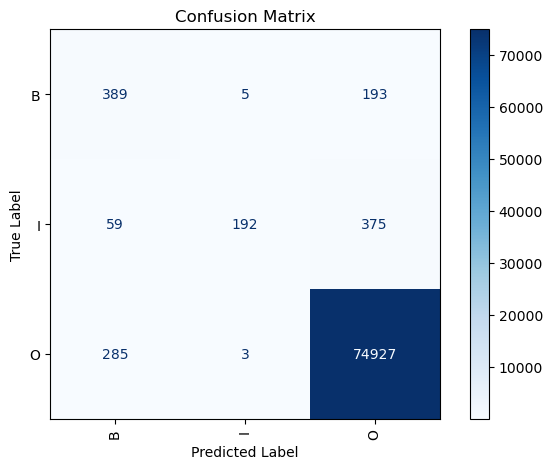

In [80]:
evaluator(price_true, price_preds, labels)

#### Using `v_f1t0`
$\to$ lexical look-up: `NAME`, `LOCATION`, `NATION`, `MARKET`, `TIME`, `GOD`\
$\to$ regular expression: `DATE`, `PRICE` 

##### Lexical look-up: `NAME`

In [81]:
# open the original letters to retrieve labels

df_v = pd.read_csv(v_f1t0, sep=',')

# dropna() will drop empty values in word, which are a result of line breaks in the letters

df_v = df_v.dropna()
df_v.head(10)

,word_id,word,NAME,LOCATION,NATION,MARKET,DATE,TIME,PRICE,GOD,labels
0,SB_J_1.0.0,1.,O,O,O,O,O,O,O,O,O
1,SB_J_1.0.1,HOTEL,B,O,O,O,O,O,O,O,NAME-B
2,SB_J_1.0.2,JOHNSON,I,O,O,O,O,O,O,O,NAME-I
3,SB_J_1.0.3,TO,O,O,O,O,O,O,O,O,O
4,SB_J_1.0.4,JOHN,B,O,O,O,O,O,O,O,NAME-B
5,SB_J_1.0.5,JOHNSON,I,O,O,O,O,O,O,O,NAME-I
6,SB_J_1.1.0,At,O,O,O,O,O,O,O,O,O
7,SB_J_1.1.1,"London,",O,B,O,O,O,O,O,O,LOCATION-B
8,SB_J_1.1.2,the,O,O,O,O,B,O,O,O,DATE-B
9,SB_J_1.1.3,12th,O,O,O,O,I,O,O,O,DATE-I


In [82]:
# VARD transformed some single tokens into multiple tokens

df_whitespace_rows = df_v[df_v['word'].str.contains('\s')]
print(len(df_v[df_v['word'].str.contains('\s')]))
df_whitespace_rows.head(10)

88


,word_id,word,NAME,LOCATION,NATION,MARKET,DATE,TIME,PRICE,GOD,labels
264,SB_J_1.3.185,how be it,O,O,O,O,O,O,O,O,O
555,SB_J_2.2.45,"How be it,",O,O,O,O,O,O,O,O,O
3986,SB_J_8.2.81,how be it,O,O,O,O,O,O,O,O,O
4107,SB_J_8.2.202,How be it,O,O,O,O,O,O,O,O,O
6128,SB_J_14.4.50,How be it,O,O,O,O,O,O,O,O,O
6211,SB_J_14.6.28,"How be it,",O,O,O,O,O,O,O,O,O
7563,SB_J_18.14.67,"How be it,",O,O,O,O,O,O,O,O,O
7714,SB_J_21.6.56,"Were it,",I,O,O,O,O,O,O,O,NAME-I
7740,SB_J_21.6.82,the other,O,O,O,O,O,O,O,O,O
10121,SB_J_33.7.62,"As well,",O,B,O,O,O,O,O,O,LOCATION-B


In [83]:
# split the word values with whitespace on whitespace creating new rows for each token and preserving the true labels

new_rows = []
for index, row in df_v.iterrows():
    tokens = row['word'].split()
    if len(tokens) ==1:
        row['token'] = row['word']
        new_rows.append(row)
    else:
        for i, token in enumerate(tokens):
            row_copy = df_v.loc[index].copy()
            row_copy['token'] = token
            cols = ['NAME', 'LOCATION', 'NATION', 'MARKET', 'DATE', 'TIME', 'PRICE', 'GOD']
            if i > 0:
                for column in cols:
                    if row_copy[column] == 'B':
                        row_copy[column] = 'I'
                row_copy['word_id'] += f'.{i}'
                row_copy['word'] = ''
            new_rows.append(row_copy)

# add new row of tokenized words to df_v

df_v = pd.concat(new_rows, axis=1).transpose().reset_index(drop=True)

# reorder the columns for readability

df_v.insert(2, 'token', df_v.pop('token'))

In [84]:
# check for the presence of tokens with whitespace

print(len(df_v[df_v['token'].str.contains('\s')]))

0


In [85]:
# construct list of lists of tuples, with each list of tuples representing one sentence and its labels

raw_data = [list(zip(g['token'], g['NAME'])) for k, g in 
            df_v.groupby(df_v['word_id'].str.endswith('.0').cumsum())]

# shuffle data

random.shuffle(raw_data)

In [86]:
# split the data into train and test

dist = get_distribution(raw_data)
train_bin, test_bin = splitter(raw_data, splitter_split, dist)

# check the splits

len(raw_data), len(train_bin), len(test_bin)

Desired split: 0.8
Actual split: 0.8005


(1692, 1374, 318)

In [87]:
# preprocess training and test data

train_bin = preprocess_for_lexical(train_bin)
test_bin = preprocess_for_lexical(test_bin)

# make lexicon for labels

lexical_dict = lexi_maker(train_bin)

# make predictions

name_pred = predict_labels(test_bin, lexical_dict)

In [88]:
# check lengths

len(name_pred[0]), len(name_pred[1]), len(name_pred[2]), len(test_bin[0]), len(test_bin[1]), len(test_bin[2])

(1, 15, 248, 1, 15, 248)

In [89]:
# create list of predictions

name_preds = [f[1] for sublist in name_pred for f in sublist]

# create list of true labels

name_true = [f[1] for sublist in test_bin for f in sublist]

##### Evaluation

accuracy: 0.8566424322538004
f1 average: 0.5591100328064392

precision: [0.23345818 0.27524576 0.98952373]
recall: [0.85388128 0.66094421 0.86313792]
f1: [0.36666667 0.38864353 0.9220199 ]

              precision    recall  f1-score   support

           B       0.23      0.85      0.37       438
           I       0.28      0.66      0.39       466
           O       0.99      0.86      0.92     14226

    accuracy                           0.86     15130
   macro avg       0.50      0.79      0.56     15130
weighted avg       0.95      0.86      0.89     15130



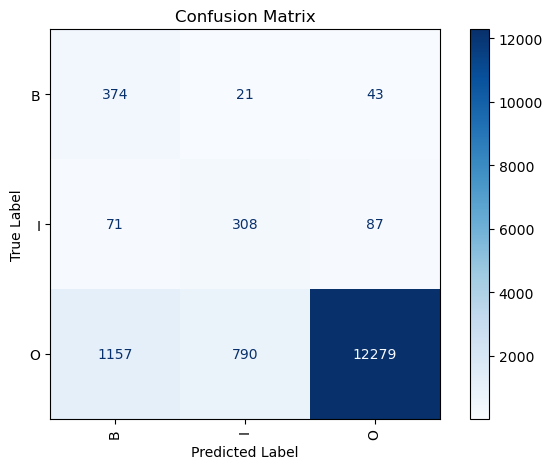

In [90]:
evaluator(name_true, name_preds, labels)

##### Lexical look-up: `LOCATION`

In [91]:
# construct list of lists of tuples, with each list of tuples representing one sentence and its labels

raw_data = [list(zip(g['token'], g['LOCATION'])) for k, g in 
            df_v.groupby(df_v['word_id'].str.endswith('.0').cumsum())]

# shuffle data

random.shuffle(raw_data)

In [92]:
# split the data into train and test

dist = get_distribution(raw_data)
train_bin, test_bin = splitter(raw_data, splitter_split, dist)

# check the splits

len(raw_data), len(train_bin), len(test_bin)

Desired split: 0.8
Actual split: 0.8016


(1692, 1406, 286)

In [93]:
# preprocess training and test data

train_bin = preprocess_for_lexical(train_bin)
test_bin = preprocess_for_lexical(test_bin)

# make lexicon for labels

lexical_dict = lexi_maker(train_bin)

# make predictions

loc_pred = predict_labels(test_bin, lexical_dict)

In [94]:
# check lengths

len(loc_pred[0]), len(loc_pred[1]), len(loc_pred[2]), len(test_bin[0]), len(test_bin[1]), len(test_bin[2])

(15, 10, 4, 15, 10, 4)

In [95]:
# create list of predictions

loc_preds = [f[1] for sublist in loc_pred for f in sublist]

# create list of true labels

loc_true = [f[1] for sublist in test_bin for f in sublist]

##### Evaluation

accuracy: 0.8846340617412418
f1 average: 0.4322565586925074

precision: [0.20682303 0.01348315 0.99674267]
recall: [0.84716157 0.57142857 0.8857042 ]
f1: [0.33247644 0.02634468 0.93794856]

              precision    recall  f1-score   support

           B       0.21      0.85      0.33       229
           I       0.01      0.57      0.03        21
           O       1.00      0.89      0.94     14165

    accuracy                           0.88     14415
   macro avg       0.41      0.77      0.43     14415
weighted avg       0.98      0.88      0.93     14415



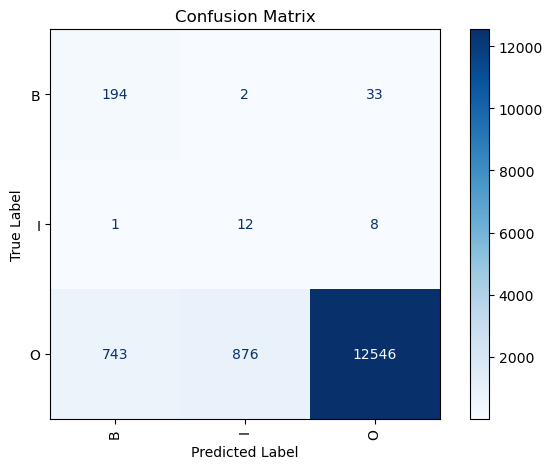

In [96]:
evaluator(loc_true, loc_preds, labels)

##### Lexical look-up: `NATION`

In [97]:
# construct list of lists of tuples, with each list of tuples representing one sentence and its labels

raw_data = [list(zip(g['token'], g['NATION'])) for k, g in 
            df_v.groupby(df_v['word_id'].str.endswith('.0').cumsum())]

# shuffle data

random.shuffle(raw_data)

In [98]:
# split the data into train and test

dist = get_distribution(raw_data)
train_bin, test_bin = splitter(raw_data, splitter_split, dist)

# check the splits

len(raw_data), len(train_bin), len(test_bin)

Desired split: 0.8
Actual split: 0.8018


(1692, 1377, 315)

In [99]:
# preprocess training and test data

train_bin = preprocess_for_lexical(train_bin)
test_bin = preprocess_for_lexical(test_bin)

# make lexicon for labels

lexical_dict = lexi_maker(train_bin)

# make predictions

nat_pred = predict_labels(test_bin, lexical_dict)

In [100]:
# check lengths

len(nat_pred[0]), len(nat_pred[1]), len(nat_pred[2]), len(test_bin[0]), len(test_bin[1]), len(test_bin[2])

(2, 119, 1, 2, 119, 1)

In [101]:
# create list of predictions

nat_preds = [f[1] for sublist in nat_pred for f in sublist]

# create list of true labels

nat_true = [f[1] for sublist in test_bin for f in sublist]

##### Evaluation

accuracy: 0.9547148971420683
f1 average: 0.46346137024359635

precision: [0.01984733 0.42857143 0.99927662]
recall: [0.59090909 0.33333333 0.95565548]
f1: [0.03840473 0.375      0.97697938]

              precision    recall  f1-score   support

           B       0.02      0.59      0.04        22
           I       0.43      0.33      0.38         9
           O       1.00      0.96      0.98     14455

    accuracy                           0.95     14486
   macro avg       0.48      0.63      0.46     14486
weighted avg       1.00      0.95      0.98     14486



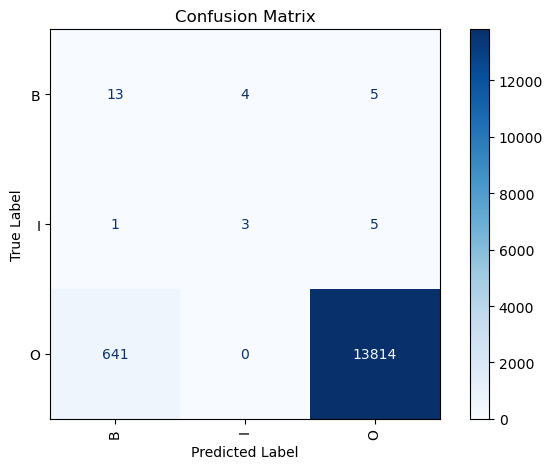

In [102]:
evaluator(nat_true, nat_preds, labels)

##### Lexical look-up: `MARKET`

In [103]:
# construct list of lists of tuples, with each list of tuples representing one sentence and its labels

raw_data = [list(zip(g['token'], g['MARKET'])) for k, g in 
            df_v.groupby(df_v['word_id'].str.endswith('.0').cumsum())]

# shuffle data

random.shuffle(raw_data)

In [104]:
# split the data into train and test

dist = get_distribution(raw_data)
train_bin, test_bin = splitter(raw_data, splitter_split, dist)

# check the splits

len(raw_data), len(train_bin), len(test_bin)

Desired split: 0.8
Actual split: 0.8033


(1692, 1234, 458)

In [105]:
# preprocess training and test data

train_bin = preprocess_for_lexical(train_bin)
test_bin = preprocess_for_lexical(test_bin)

# make lexicon for labels

lexical_dict = lexi_maker(train_bin)

# make predictions

mark_pred = predict_labels(test_bin, lexical_dict)

In [106]:
# check lengths

len(mark_pred[0]), len(mark_pred[1]), len(mark_pred[2]), len(test_bin[0]), len(test_bin[1]), len(test_bin[2])

(177, 166, 6, 177, 166, 6)

In [107]:
# create list of predictions

mark_preds = [f[1] for sublist in mark_pred for f in sublist]

# create list of true labels

mark_true = [f[1] for sublist in test_bin for f in sublist]

##### Evaluation

accuracy: 0.9370099050763516
f1 average: 0.4520146392420575

precision: [0.00916667 0.25       0.99988977]
recall: [0.91666667 0.71428571 0.93718359]
f1: [0.01815182 0.37037037 0.96752173]

              precision    recall  f1-score   support

           B       0.01      0.92      0.02        12
           I       0.25      0.71      0.37        14
           O       1.00      0.94      0.97     19358

    accuracy                           0.94     19384
   macro avg       0.42      0.86      0.45     19384
weighted avg       1.00      0.94      0.97     19384



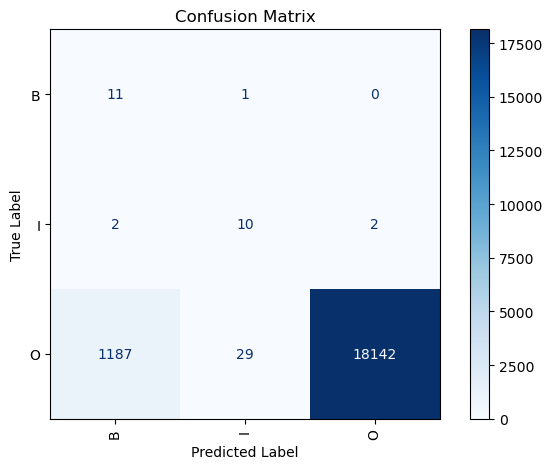

In [108]:
evaluator(mark_true, mark_preds, labels)

##### Lexical look-up: `TIME`

In [109]:
# construct list of lists of tuples, with each list of tuples representing one sentence and its labels

raw_data = [list(zip(g['token'], g['TIME'])) for k, g in 
            df_v.groupby(df_v['word_id'].str.endswith('.0').cumsum())]

# shuffle data

random.shuffle(raw_data)

In [110]:
# split the data into train and test

dist = get_distribution(raw_data)
train_bin, test_bin = splitter(raw_data, splitter_split, dist)

# check the splits

len(raw_data), len(train_bin), len(test_bin)

Desired split: 0.8
Actual split: 0.8063


(1692, 1351, 341)

In [111]:
# preprocess training and test data

train_bin = preprocess_for_lexical(train_bin)
test_bin = preprocess_for_lexical(test_bin)

# make lexicon for labels

lexical_dict = lexi_maker(train_bin)

# make predictions

time_pred = predict_labels(test_bin, lexical_dict)

In [112]:
# check lengths

len(time_pred[0]), len(time_pred[1]), len(time_pred[2]), len(test_bin[0]), len(test_bin[1]), len(test_bin[2])

(6, 44, 32, 6, 44, 32)

In [113]:
# create list of predictions

time_preds = [f[1] for sublist in time_pred for f in sublist]

# create list of true labels

time_true = [f[1] for sublist in test_bin for f in sublist]

##### Evaluation

accuracy: 0.6819672131147541
f1 average: 0.31415121285488606

precision: [0.03992114 0.02958978 0.99843857]
recall: [0.82653061 0.75213675 0.68047888]
f1: [0.07616361 0.0569395  0.80935053]

              precision    recall  f1-score   support

           B       0.04      0.83      0.08        98
           I       0.03      0.75      0.06       117
           O       1.00      0.68      0.81     15035

    accuracy                           0.68     15250
   macro avg       0.36      0.75      0.31     15250
weighted avg       0.98      0.68      0.80     15250



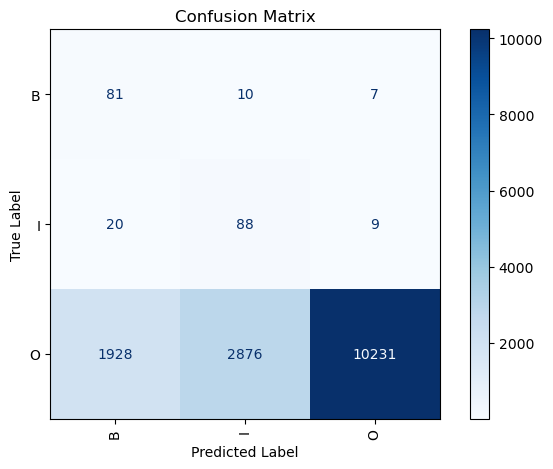

In [114]:
evaluator(time_true, time_preds, labels)

##### Lexical look-up: `GOD`

In [115]:
# construct list of lists of tuples, with each list of tuples representing one sentence and its labels

raw_data = [list(zip(g['token'], g['GOD'])) for k, g in 
            df_v.groupby(df_v['word_id'].str.endswith('.0').cumsum())]

# shuffle data

random.shuffle(raw_data)

In [116]:
# split the data into train and test

dist = get_distribution(raw_data)
train_bin, test_bin = splitter(raw_data, splitter_split, dist)

# check the splits

len(raw_data), len(train_bin), len(test_bin)

Desired split: 0.8
Actual split: 0.8014


(1692, 1350, 342)

In [117]:
# preprocess training and test data

train_bin = preprocess_for_lexical(train_bin)
test_bin = preprocess_for_lexical(test_bin)

# make lexicon for labels

lexical_dict = lexi_maker(train_bin)

# make predictions

god_pred = predict_labels(test_bin, lexical_dict)

In [118]:
# check lengths

len(god_pred[0]), len(god_pred[1]), len(god_pred[2]), len(test_bin[0]), len(test_bin[1]), len(test_bin[2])

(2, 66, 65, 2, 66, 65)

In [119]:
# create list of predictions

god_preds = [f[1] for sublist in god_pred for f in sublist]

# create list of true labels

god_true = [f[1] for sublist in test_bin for f in sublist]

##### Evaluation

accuracy: 0.9118773946360154
f1 average: 0.36000557476960343

precision: [0.0508647  0.01517707 0.9999361 ]
recall: [0.90909091 0.69230769 0.91205269]
f1: [0.09633911 0.02970297 0.95397464]

              precision    recall  f1-score   support

           B       0.05      0.91      0.10        55
           I       0.02      0.69      0.03        13
           O       1.00      0.91      0.95     17158

    accuracy                           0.91     17226
   macro avg       0.36      0.84      0.36     17226
weighted avg       1.00      0.91      0.95     17226



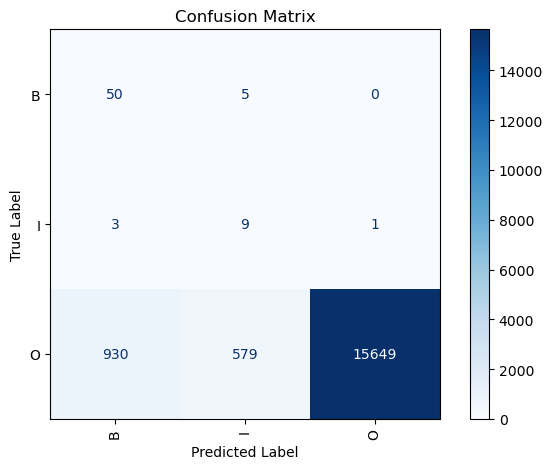

In [120]:
evaluator(god_true, god_preds, labels)

##### Regular expression: `DATE`
$\to$ iterating through NER Subcorpus by line

In [121]:
# the file v_f1t0.json prepared for spaCy is suitable to use here as it contains the entire VARDed NER subcorpus as a list of strings

with open('v_f1t0.json') as file:
    data = json.load(file)

# save string of VARDed NER subcorpus text

text_v_f1t0 = ' '.join(data)

In [122]:
# find regex pattern matches and create labels

pattern = r"\b(the\s)?(\d{1,2})(?:(th|st|nd|rd)\b)?(?=\s)"

# find matches, create finditer iterator

matches = re.finditer(pattern, text_v_f1t0)

# split text

words = text_v_f1t0.split()

# store the labels

date_labels = ['O'] * len(words)

# iterate over the matches and update the date_labels

for match in matches:
    start_index = match.start()
    end_index = match.end()

    # split the matched words
    matched_words = text_v_f1t0[start_index:end_index].split()

    # label the first word as 'B'
    date_labels[words.index(matched_words[0])] = 'B'

    # label subsequent words as 'I'
    for i in range(1, len(matched_words)):
        date_labels[words.index(matched_words[i])] = 'I'

In [123]:
# create list of true labels 

date_true = df_v['DATE'].tolist()

##### Evaluation

accuracy: 0.9721521963453024
f1 average: 0.34178686828713273

precision: [0.11764706 0.69565217 0.97280513]
recall: [0.01022147 0.01043025 0.99955668]
f1: [0.01880878 0.02055234 0.98599948]

              precision    recall  f1-score   support

           B       0.12      0.01      0.02       587
           I       0.70      0.01      0.02      1534
           O       0.97      1.00      0.99     74438

    accuracy                           0.97     76559
   macro avg       0.60      0.34      0.34     76559
weighted avg       0.96      0.97      0.96     76559



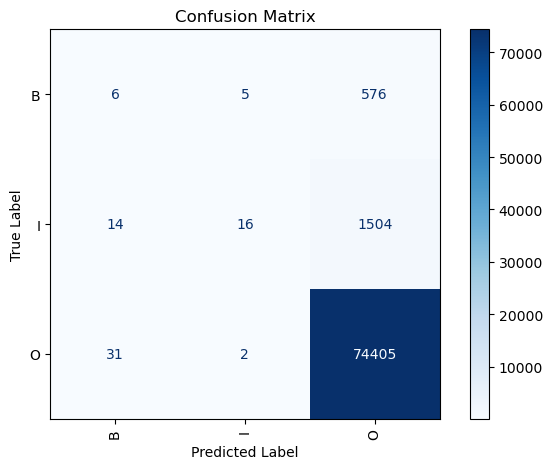

In [124]:
evaluator(date_true, date_labels, labels)

##### Regular expression: `PRICE`
$\to$ iterating through the `df` to match on word tokens

In [125]:
# same patterns

B_patterns = ["\\b\w*li\\b|\\bli\\b", "\\b.*ij\\b", "\w*xx\w*"]
I_patterns = ["\\bst\.", "\\bFl\."]

In [126]:
# iterate through letters by token and search for matches

df_v['PRICE_re_labels'] = df_v['token'].apply(lambda x: check_regex(x))

# check df_v

df_v.head()

,word_id,word,token,NAME,LOCATION,NATION,MARKET,DATE,TIME,PRICE,GOD,labels,PRICE_re_labels
0,SB_J_1.0.0,1.,1.,O,O,O,O,O,O,O,O,O,O
1,SB_J_1.0.1,HOTEL,HOTEL,B,O,O,O,O,O,O,O,NAME-B,O
2,SB_J_1.0.2,JOHNSON,JOHNSON,I,O,O,O,O,O,O,O,NAME-I,O
3,SB_J_1.0.3,TO,TO,O,O,O,O,O,O,O,O,O,O
4,SB_J_1.0.4,JOHN,JOHN,B,O,O,O,O,O,O,O,NAME-B,O


In [127]:
# create list of predictions

price_preds = df_v['PRICE_re_labels'].tolist()

# create list of true labels 

price_true = df_v['PRICE'].tolist()

##### Evaluation

accuracy: 0.9883488551313366
f1 average: 0.6274153228844447

precision: [0.66995074 0.96992481 0.99008156]
recall: [0.46337308 0.20607029 0.99893823]
f1: [0.54783484 0.33992095 0.99449018]

              precision    recall  f1-score   support

           B       0.67      0.46      0.55       587
           I       0.97      0.21      0.34       626
           O       0.99      1.00      0.99     75346

    accuracy                           0.99     76559
   macro avg       0.88      0.56      0.63     76559
weighted avg       0.99      0.99      0.99     76559



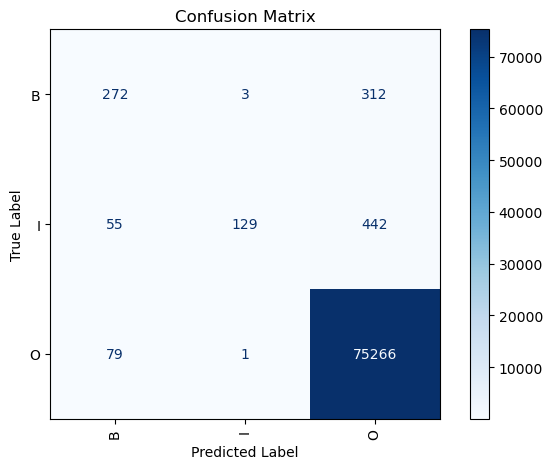

In [128]:
evaluator(price_true, price_preds, labels)